<h3 style="text-align: center;"><b>«Практическое занятие по дисперсионному анализу и A/B тестам»</b></h3>

In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import math
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.power import tt_solve_power
import seaborn as sns

#  Дисперсионный анализ

Рассмотренный ранее **t-критерий Стьюдента** (равно как и его непараметрические аналоги) предназначен для сравнения исключительно **двух совокупностей**. В таком случае мы можем применять однофакторный дисперсионный анализ.  Та переменная, которая будет разделять наших испытуемых или наблюдения на группы (номинативная переменная с нескольким градациями) называется **независимой переменной**. А та количественная переменная, по степени выраженности которой мы сравниваем группы, называется **зависимая переменная**. 


$$ SS_{total} = \sum_{j=1}^{p}{\sum_{i=1}^{n_j}{(x_{ij} - \bar{x})^2}} = SS_{between} + SS_{within} $$
$$ SS_{between} = \sum_{j=1}^{p}{n_j{(\bar{x}_j - \bar{x})^2}} $$
$$ SS_{within} = \sum_{j=1}^{p}{\sum_{i=1}^{n_j}{(x_{ij} - \bar{x}_j)^2}} $$


Нулевая гипотеза: a=b=c
Альтернативная гипотеза: !(a=b=c)
Результат:
отклоняем нулевую гипотезу
Полученное f-значение 12.0


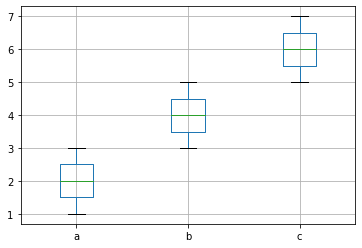

In [2]:
# Выборки которые надо сравнить
data =\
    pd.DataFrame({
        'a': [3, 1, 2],
        'b': [5, 3, 4],
        'c': [7, 6, 5]
    })
data.boxplot()
print('Нулевая гипотеза:', '='.join(data))
print('Альтернативная гипотеза:', f'!({"=".join(data)})')
# Общая средняя
grand_mean = data.values.flatten().mean()
# Общая сумма квадратов sst = ssb + ssw
sst = sum((val - grand_mean)**2 for val in data.values.flatten())
# Отклонение групповых средний от общей средней
ssb = sum(data[group].size * (group_mean - grand_mean) ** 2 for group, group_mean in data.mean().items())
# Отклонения значений внутри группы от средней группы
ssw = sum(sum((x - group_mean)**2 for x in data[group]) for group, group_mean in data.mean().items())

groups = data.shape[1]
# Степени свободы
dfb = groups - 1
dfw = data.size - groups
# Межгрупповой средний квадрат
mssb = ssb/dfb
# Внутригрупповой средний квадрат
mssw = ssw/dfw

f_value = mssb/mssw

p = st.f.sf(f_value, dfb, dfw)
print('Результат:')
if p < 0.05:
    print('отклоняем нулевую гипотезу')
else:
    print('НЕ отклоняем нулевую гипотезу')
print(f"Полученное f-значение {f_value}")

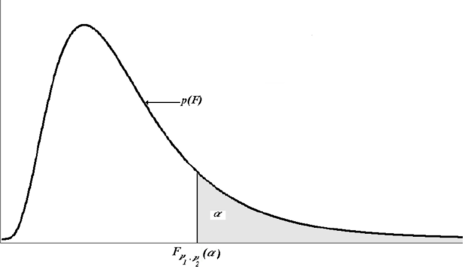

In [3]:
# Распределение F-значения
from IPython.display import Image
Image('fisher_dist.png')

In [4]:
dfb

2

In [5]:
dfw

6

In [6]:
p

0.008000000000000002

Посмотрим, на распределение в нашем случае
- https://gallery.shinyapps.io/dist_calc/ 



Проанализируем синтетический датасет с данными. У нас есть наблюдения по 4 группам. Предположим, что это данные о результатах исследования эффективности четырех препаратов и нам нужно определить если между этими результатами статистически значимая разница.

In [7]:
df =\
    pd.DataFrame([[25, 45, 30, 54],
                  [30, 55, 29, 60],
                  [28, 29, 33, 51],
                  [36, 56, 37, 62],
                  [29, 40, 27, 73]],
                 columns=['A', 'B', 'C', 'D'])
df

,A,B,C,D
0,25,45,30,54
1,30,55,29,60
2,28,29,33,51
3,36,56,37,62
4,29,40,27,73


In [8]:
df_melt = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['A', 'B', 'C', 'D'])
df_melt.columns = ['index', 'treatments', 'value']
df_melt

,index,treatments,value
0,0,A,25
1,1,A,30
2,2,A,28
3,3,A,36
4,4,A,29
5,0,B,45
6,1,B,55
7,2,B,29
8,3,B,56
9,4,B,40


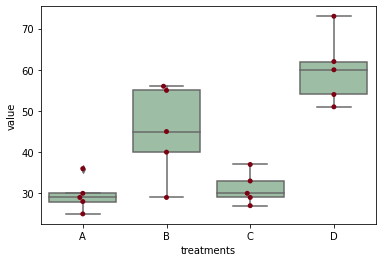

In [9]:
ax = sns.boxplot(x='treatments', y='value', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="treatments", y="value", data=df_melt, color='#7d0013')
plt.show()

In [10]:
import scipy.stats as stats

fvalue, pvalue = stats.f_oneway(df['A'], df['B'], df['C'], df['D'])

print('Статистика=%.3f, p=%.6f' % (fvalue, pvalue))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, средние, вероятно, различаются')

Статистика=17.493, p=0.000026
Отклоняем нулевую гипотезу, средние, вероятно, различаются


**Почему мы не можем применить t-критерий для более двух выборок применяя его попарно к каждой выбрке**

Чтобы выяснить это, сделаем эксперемент.

In [11]:
from numpy import random
from scipy.stats import t

def pair_t(samples, alpha):
    '''Парный t-критерий, если все выборки равны, возвращает True'''
    n_samples = samples.shape[0]
    # https://ru.wikipedia.org/wiki/Сочетание
    n_combinations = n_samples*(n_samples - 1)//2
    result = np.zeros(n_combinations, dtype=bool)
    k = 0
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            N = samples[i].size
            std_err = np.sqrt((samples[i].std()**2) /
                              N + (samples[j].std()**2)/N)
            t_value = (samples[i].mean() + samples[j].mean())/std_err
            p = t.sf(t_value, N-2)
            result[k] = p >= alpha
            k += 1
    return np.all(result)


def pair_t_test(repeat, n_samples, sample_size, ax, alpha=0.05):
    '''
    функция показывает, сколько у нас будет ложных результатов, при парном сравнение множества выборок
    с помощью t-критерия

    repeat - количество повторов
    n_samples - количество выборок в каждом повторе
    sample_size - размер выборки

    ax - для рисования
    alpha = (1 - (p-уровень значимости))
    '''
    result = np.zeros(repeat, dtype=bool)
    for i in range(repeat):
        samples = random.randn(n_samples, sample_size)
        result[i] = pair_t(samples, alpha)

    unique, counts = np.unique(result, return_counts=True)
    percentage = counts/result.size
    ax.pie(percentage, labels=unique, autopct='%.0f%%')

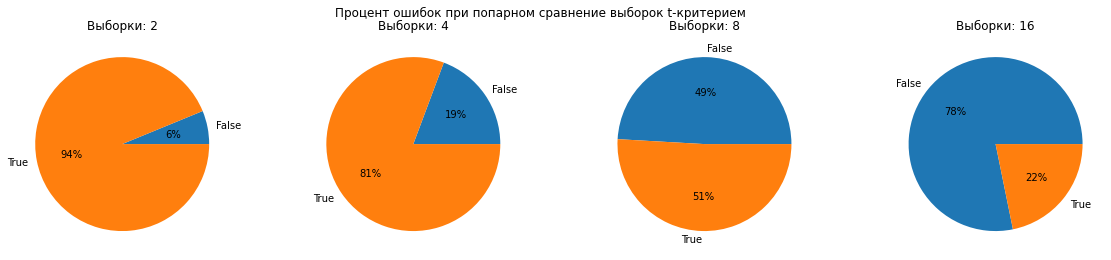

In [12]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 4))
n_samples = [2, 4, 8, 16]
fig.suptitle('Процент ошибок при попарном сравнение выборок t-критерием')

for n, ax in zip(n_samples, axs):
    pair_t_test(1000, n, 30, ax)
    ax.set_title(f'Выборки: {n}')
    

Как мы и ожидаем, степень ошибки равна **5%**, при сравнение **двух выборок** из одной ГС с помощью t-критерия с p-уровнем значимости **95%**. Если мы возмём **4** выборки, и сравним их попарно, то ошибка возрастёт в **4** раза до **20%**. При **8** выборок, наша ошибка возрасла почти в **9** раз до **46%**. **16** выборок дают увеличение ошибки до **80%** ( в 16 раз), что совершенно неприемлемо.

KeyboardInterrupt: 

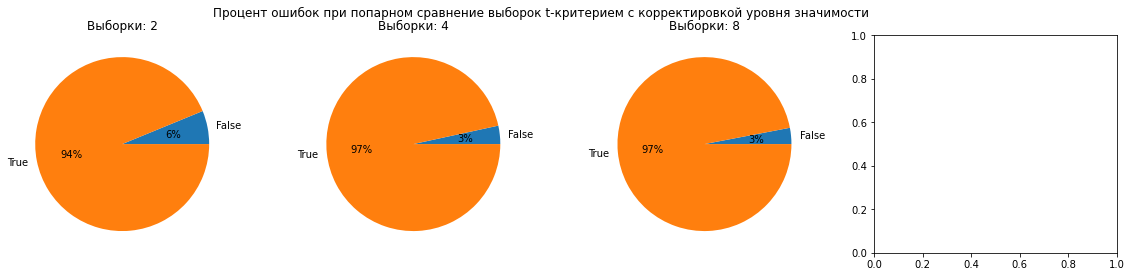

In [13]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 4))
n_samples = [2, 4, 8, 16]
fig.suptitle('Процент ошибок при попарном сравнение выборок t-критерием с корректировкой уровня значимости')

for n, ax in zip(n_samples, axs):
    alpha = 0.05/((n*(n-1))/2) # делим на число сравнений = ((n*(n-1))/2) - поправка Бонферрони 
    pair_t_test(1000, n, 30, ax, alpha)
    ax.set_title(f'Выборки: {n}')

Однако в данном мы **уменьшаем шанс получить ошибку I рода, но увеличиваем шанс на ошибку II рода**.


In [ ]:
plt.figure(figsize=(12,10))


plt.fill_between(x=np.arange(-4,-2,0.01), 
                 y1= st.norm.pdf(np.arange(-4,-2,0.01)) ,
                 facecolor='red',
                 alpha=0.35)

plt.fill_between(x=np.arange(-2,2,0.01), 
                 y1= st.norm.pdf(np.arange(-2,2,0.01)) ,
                 facecolor='grey',
                 alpha=0.35)

plt.fill_between(x=np.arange(2,4,0.01), 
                 y1= st.norm.pdf(np.arange(2,4,0.01)) ,
                 facecolor='red',
                 alpha=0.5)

plt.fill_between(x=np.arange(-4,-2,0.01), 
                 y1= st.norm.pdf(np.arange(-4,-2,0.01),loc=3, scale=2) ,
                 facecolor='grey',
                 alpha=0.35)

plt.fill_between(x=np.arange(-2,2,0.01), 
                 y1= st.norm.pdf(np.arange(-2,2,0.01),loc=3, scale=2) ,
                 facecolor='blue',
                 alpha=0.35)

plt.fill_between(x=np.arange(2,10,0.01), 
                 y1= st.norm.pdf(np.arange(2,10,0.01),loc=3, scale=2),
                 facecolor='grey',
                 alpha=0.35)

plt.text(x=-0.8, y=0.15, s= "Нулевая\nгипотеза")
plt.text(x=2.5, y=0.13, s= "Альтернативная\nгипотеза")
plt.text(x=2.1, y=0.01, s= "Ошибка\nпервого\nрода")
plt.text(x=-3.2, y=0.01, s= "Ошбика\nпервого\nрода")
plt.text(x=0, y=0.02, s= "Ошибка\nвторого рода");

In [ ]:
tt_solve_power(effect_size = 0.5,
               alpha = 0.01,
               power = 0.99)

In [ ]:
groups = ['A','B','C','D']
names = [];
for k1 in range (len(groups)):
    for k2 in range(len(df['A'])):
        names.append(groups[k1])

In [ ]:
tukey = pairwise_tukeyhsd(endog=pd.concat([df['A'], df['B'],df['C'],df['D']]).values,
                          groups=names,
                          alpha=0.05)
print(tukey)

In [ ]:
tukey.plot_simultaneous(comparison_name="C")

### Тест Краскела-Уоллиса
Непараметрическая альтернатива одномерному (межгрупповому) дисперсионному анализу. Он используется для сравнения трех или более выборок, и проверяет нулевые гипотезы, согласно которым различные выборки были взяты из одного и того же распределения, или из распределений с одинаковыми медианами

Допущения

* Наблюдения независимы друг от друга.
* Наблюдения можно проранжировать.

Гипотеза

* H0: Все распределения одинаковы.
* H1: Одно или несколько распределений различаются.

In [ ]:
data1 = [6.873, 4.817, 4.121, -0.045, -0.055, -0.0436, 4.360, -0.478, -0.0637, -0.089]
data2 = [1.142, -0.432, -0.938, -0.729, -0.846, -0.157, 0.500, 1.183, -1.075, -0.169]
data3 = [-0.208, 0.696, 0.928, -1.148, -0.213, 0.229, 0.137, 0.269, -0.870, -1.204]

stat, p = st.kruskal(data1, data2, data3)

print(f"Статистика = {stat:.3f}, p = {p:.3f}")

if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

In [ ]:
stats.f_oneway(data1, data2, data3)

In [ ]:
import scikit_posthocs as sp

sp.posthoc_dunn(data, p_adjust = 'bonferroni')

## Тесты на нормальность данных
### Тест Шапиро-Уилка
Проверяет распределены ли данные по нормальному закону.

Допущения

* Наблюдения независимы друг от друга.

Гипотеза

* H0: Данные распределены по нормальному закону.
* H1: Данные не распределены по нормальному закону.

In [ ]:
data = [0.873, 2.817, 0.121, -0.945, -0.055, -1.436, 0.360, -1.478, -1.637, -1.869]

stat, p = st.shapiro(data)

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Вероятно нормальное распределение')
else:
    print('Вероятно не нормальное распределение')

### Тест Андерсона-Дарлинга
Проверяет распределены ли данные по нормальному закону.

Допущения

* Наблюдения независимы друг от друга.

Гипотеза

* H0: Данные распределены по нормальному закону.
* H1: Данные не распределены по нормальному закону.

In [ ]:
data = [0.873, 2.817, 0.121, -0.945, -0.055, -1.436, 0.360, -1.478, -1.637, -1.869]
result = st.anderson(data)

In [ ]:
result

In [ ]:
print('stat=%.3f' % (result.statistic))
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print('Вероятно нормальное на уровне %.1f%%' % (sl))
    else:
        print('Вероятно не нормальное на уровне %.1f%%' % (sl))

### Тест Колмогорова-Смирнова

In [ ]:
#generate dataset of 100 values that follow a Poisson distribution with mean=5
data = np.random.normal(0,1,30)

In [ ]:
data

In [ ]:
#perform Kolmogorov-Smirnov test
stat, p = st.kstest(data, 'norm')
print(f"Статистика = {stat:.5f}, p = {p:.15f}")

In [ ]:
#generate two datasets
data1 = np.random.randn(100)
data2 = np.random.lognormal(3, 1, 100)

In [ ]:
stat, p = st.ks_2samp(data1, data2)
print(f"Статистика = {stat:.5f}, p = {p:.5f}")

## Пример проведения A/B теста

Давайте представим, что вы работаете в команде разработчиков **онлайн-бизнеса электронной коммерции**. UX-дизайнер очень усердно работал над новой версией страницы продукта в надежде, что это приведет к более высокому коэффициенту конверсии. Менеджер по продукту сказал вам, что **текущий коэффициент конверсии** составляет около **13%** в среднем в течение года, и что команда была бы рада **увеличению на 2%**, что означает что новый дизайн будет считаться успешным, если он поднимет коэффициент конверсии до 15%.

Прежде чем внедрять изменение, команде было бы удобнее протестировать его на небольшом количестве пользователей, чтобы увидеть, как оно работает, поэтому вы предлагаете провести **A/B-тест** на подмножестве пользователей вашей пользовательской базы.

### 1. Планирование эксперимента

Прежде всего, необходимо сформулировать нулевую гипотезу, чтобы не ошибиться при интерпретации результатов.

Поскольку мы не знаем, будет ли новый дизайн работать лучше или хуже (или будет таким же?), как наш текущий дизайн, мы выберем <a href="https://en.wikipedia.org/wiki/One-_and_two-tailed_tests">**двусторонний тест**</a>:

$$H_0: p = p_0$$
$$H_a: p \ne p_0$$

где $p$ и $p_0$ — коэффициент конверсии нового и старого дизайна соответственно. Мы также установим **уровень достоверности 95%**:

$$\alpha = 0,05$$

Для нашего теста нам понадобятся **две группы**:
* Контрольная группа (`control`)  - им будет показан старый дизайн
* Экспериментальная группа (`treatment`) — им будет показан новый дизайн.

Это будет наша *Независимая переменная*. Причина, по которой у нас есть две группы, несмотря на то, что мы знаем базовый коэффициент конверсии, заключается в том, что мы хотим контролировать другие переменные, которые могут повлиять на наши результаты, такие как сезонность: имея «контрольную» группу, мы можем напрямую сравнивать их результаты с экспериментальной группой, потому что единственное систематическое различие между группами заключается в дизайне страницы продукта, и поэтому мы можем отнести любые различия в результатах к дизайну.

Для нашей *зависимой переменной* (т.е. того, что мы пытаемся измерить) нас интересует "коэффициент конверсии". Мы можем закодировать это для каждого сеанса пользователя с помощью двоичной переменной:
* `0` - Пользователь не покупал продукт в течение данной пользовательской сессии.
* `1` - Пользователь купил продукт во время этой пользовательской сессии.

Таким образом, мы можем легко рассчитать среднее значение для каждой группы, чтобы получить коэффициент конверсии для каждого дизайна.

#### Выбор размера выборки

Важно отметить, что поскольку мы не будем тестировать всю пользовательскую базу (наша генеральная совокупность), коэффициенты конверсии, которые мы получим, неизбежно будут только *оценками* истинных коэффициентов.

Количество людей (или пользовательских сеансов), которые мы решим включить в каждую группу, повлияет на точность наших оценочных коэффициентов конверсии: **чем больше размер выборки**, тем точнее наши оценки (интервалы), **тем выше шанс обнаружить разницу** в двух группах, если она присутствует.

С другой стороны, чем больше становится наша выборка, тем дороже (и непрактичнее) становится наше исследование.

Так сколько человек должно быть в каждой группе?

Необходимый нам размер выборки оценивается с помощью так называемого анализа мощности, и это зависит от нескольких факторов:
* **Мощность теста** ($1 - \beta$) - это вероятность обнаружения статистической разницы между группами в нашем тесте, когда разница действительно присутствует. Как правило, это значение равно 0,8 (если вам интересно, вот дополнительная информация о <a href="https://en.wikipedia.org/wiki/Power_of_a_test">статистической мощности</a>)
* **Альфа-значение** ($\alpha$) — критическое значение, которое мы установили ранее равным 0,05.
* **Величина эффекта** – ожидаемая разница между коэффициентами конверсии.

Поскольку нашу команду устроила бы разница в $2\%$, мы можем использовать $13\%$ и $15\%$ для расчета ожидаемой величины эффекта.

In [ ]:
# Импорт библиотек
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 16}

In [ ]:
p1=0.13
p2=0.15

In [ ]:
za = 1.96
zb = 0.84

In [ ]:
required_n = ceil(((za + zb)**2)*(p1*(1-p1)+p2*(1-p2))/((p1-p2)**2))
required_n

Нам потребуется **не менее 4716 наблюдений для каждой группы**.

Установка параметра «мощность» на 0,8 на практике означает, что если существует фактическая разница в коэффициенте конверсии между нашими дизайнами, при условии, что разница является той, которую мы оценили (13% против 15%), у нас есть около 80% шансов на успех. обнаружить его как статистически значимое в нашем тесте с рассчитанным нами размером выборки.

### 2. Сбор и подготовка данных

In [ ]:
df = pd.read_csv('ab_data.csv')

df.head()

In [ ]:
df.info()

In [ ]:
pd.crosstab(df['group'], df['landing_page'])

У нас есть **294478 строк**, каждая из которых представляет сеанс пользователя, а также **5 столбцов**:
* `user_id` - идентификатор пользователя каждой сессии
* `timestamp` - Отметка времени сеанса
* `group` — к какой группе был отнесен пользователь для этого сеанса {`control`, `treatment`}
* `landing_page` — какой дизайн видел каждый пользователь в этом сеансе {`old_page`, `new_page`}
* `converted` - закончился ли сеанс конверсией или нет (двоичный, `0`=не преобразовано, `1`=конвертировано)

На самом деле мы будем использовать для анализа только столбцы «group» и «converted».

Прежде чем мы приступим к выборке данных для получения нашего подмножества, давайте удостоверимся, что нет пользователей, которые были отобраны несколько раз.

In [ ]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'В нашем наборе данных присутствует {multi_users} повторений пользователей по ID')

In [ ]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'После очистки имеем {df.shape[0]} записей')

In [ ]:
required_n

#### Выборка

In [ ]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [ ]:
ab_test

In [ ]:
ab_test.info()

In [ ]:
ab_test['group'].value_counts()

### 3. Визуализация

In [ ]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              
se_p = lambda x: stats.sem(x, ddof=0)            # (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['конверсия', 'сред. кв. отклонение', 'ошибка среднего']


conversion_rates.style.format('{:.3f}')

Судя по приведенной выше статистике, похоже, что **наши два проекта работали очень похоже**, а наш новый дизайн работал немного лучше - **коэффициент конверсии 12,3% против 12,6%**.

Визуализация данных облегчит понимание этих результатов:

In [ ]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Конверсия по группам', pad=20)
plt.xlabel('Группа', labelpad=15)
plt.ylabel('Конверсия (пропорция)', labelpad=15);

Коэффициенты конверсии для наших групп действительно очень близки. Также обратите внимание, что коэффициент конверсии «контрольной» группы ниже, чем мы ожидали, учитывая то, что мы знали о нашем среднем значении. коэффициент конверсии (12,3% против 13%). Это говорит о том, что при выборке из ГС есть некоторые различия в результатах.

Ценность экспериментальной группы выше. **Является ли эта разница *статистически значимой***?

### 4. Проверка гипотезы

Последним шагом нашего анализа является проверка нашей гипотезы. Так как у нас очень большая выборка, мы можем использовать <a href="https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Normal_ приблизительно_interval">нормальное приближение</a> для расчета нашего значения $p$ (т.е. z-тест).

Опять же, Python делает все вычисления очень простыми. Мы можем использовать модуль `statsmodels.stats.proportion`, чтобы получить значение $p$ и доверительные интервалы:

In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [ ]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [ ]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z-статистика: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ДИ 95% для контрольной группы: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ДИ 95% для тестовой группы: [{lower_treat:.3f}, {upper_treat:.3f}]')

### 5. Выводы

Поскольку наше значение $p=0.755$ намного превышает наше значение $\alpha=0.05$, мы не можем отвергнуть нулевую гипотезу $H_0$, а это означает, что наш новый дизайн не имел существенных отличий (не говоря уже о лучшем) от нашего старого. :(

Кроме того, если мы посмотрим на доверительный интервал для тестовой группы ( [0.116, 0.135], то есть 11,6-13,5%), то заметим, что:
1. Он включает наше базовое значение коэффициента конверсии $13\%$.
2. Он не включает наше целевое значение в $15\%$ ($2\%$ роста, к которому мы стремились).

Это означает, что более вероятно, что истинный коэффициент конверсии нового дизайна будет похож на наш базовый уровень, а не на целевые 15%, на которые мы надеялись. Это еще одно доказательство того, что наш новый дизайн вряд ли будет улучшением нашего старого дизайна!

## Еще один пример проведения A/B теста

Cookie Cats - чрезвычайно популярная мобильная игра-головоломка, разработанная Tactile Entertainment. Это классическая игра-головоломка в стиле «соедините три», в которой игрок должен соединять плитки одного цвета, чтобы очистить поле и выиграть уровень. Здесь также есть поющие кошки.

<p style="align: center;"><img align=center src="https://i.ytimg.com/vi/iPxZIp0cbJE/maxresdefault.jpg"  width=500></p>
 
 
<p style="align: center;"><img align=center src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cc_gates.png"  width=500></p>


По мере прохождения уровней игры игроки время от времени сталкиваются с воротами, которые заставляют их ждать некоторое количество времени или совершать покупки в приложении, чтобы продолжить. Помимо стимулирования покупок в приложении, эти ворота служат важной цели - дать игрокам вынужденный перерыв в игре, что, как мы надеемся, приведет к увеличению и продлению удовольствия от игры.

<b>Но где ставить ворота? </b>
Первоначально первые ворота были размещены на уровне 30. В этом проекте вам предлагается проанализировать AB-тест, в котором создатели переместили первые ворота в Cookie Cats с 30 уровня на уровень 40. В частности, вам надо рассмотрим влияние A/B теста на удержание игроков.

### Данные A/B тестирования

In [ ]:
data = pd.read_csv('cookie_cats.csv', on_bad_lines='skip')  # Откроем датасет
data.head()

**Данные получены от 90 189 игроков, которые установили игру во время проведения AB-теста. Переменные:**

* `userid` - уникальный номер, идентифицирующий каждого игрока.

* `version` - был ли игрок помещен в контрольную группу (gate_30 - ворота на уровне 30) или в тестовую группу (gate_40 - ворота на уровне 40).

* `sum_gamerounds` - количество игровых раундов, сыгранных игроком в течение первой недели после установки
* `retention_1` - проигрыватель вернулся и поиграл через 1 день после установки?
* `retention_7` - проигрыватель вернулся и играл через 7 дней после установки?

Когда игрок устанавливал игру, ему случайным образом назначали `gate_30` или `gate_40`.

<b>Задание: провести анализ данных и сделать выводы о лучшем месте для установки ворот.</b>

In [ ]:
# Посмотрим на количество участников теста.
data.groupby('version').version.count()

In [ ]:
data.groupby('version').sum()

In [ ]:
data.groupby('version').mean()

In [ ]:
v_30 = data.loc[data.version == 'gate_30']
v_40 = data.loc[data.version == 'gate_40']
v_30 = v_30.drop(v_30.loc[v_30.sum_gamerounds > 200].index)
v_40 = v_40.drop(v_40.loc[v_40.sum_gamerounds > 200].index)


bins = 200
plt.figure(figsize=(15, 10))
plt.hist(v_30['sum_gamerounds'], bins=bins, alpha=1,
         edgecolor='black', label='gate 30')
plt.hist(v_40['sum_gamerounds'], bins=bins, alpha=0.7, label='gate 40')
plt.legend(loc='upper right', bbox_to_anchor=(0.45, 0.35))
plt.show()

In [ ]:
df = data.loc[data['sum_gamerounds'] < 100].copy();

sns.catplot(x="version", y="sum_gamerounds",
            hue="retention_1", col = 'retention_7',
            data=df, kind="box",
            height=5, aspect=.95);


Какие тесты мы знаем?

In [ ]:
from scipy.stats import f_oneway
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
import scipy.stats as stats

stat, p = mannwhitneyu(data[data['version'] == 'gate_30']['sum_gamerounds'], data[data['version'] == 'gate_40']['sum_gamerounds'])

print('Статистика=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')


Применяем Bootstrap для того, чтобы более наглядно убедиться в наличии различий

In [ ]:
plt.figure(figsize=(15, 10))
# boot_1d - собираем статистику по средним, для неё можно применить t-тест
boot_1d = []
for i in range(1000):
    boot_mean = data.sample(frac=1, replace=True).groupby(
        'version')['retention_7'].mean()  # retention_1
    boot_1d.append(boot_mean)

# Преобразование списка в DataFrame
boot_1d = pd.DataFrame(boot_1d)

# График полученного распределения
boot_1d.plot(kind='density')

Прежде чем использовать t-тест, необходимо проверить равенство дисперссий. Сделаем это с помощью <a href="https://ru.wikipedia.org/wiki/F-%D1%82%D0%B5%D1%81%D1%82">F-теста</a>. Используем собстенную функцию. 

In [ ]:
def f_test(group1, group2):
    f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
    nun = group1.size-1
    dun = group2.size-1
    p_value = 1-st.f.cdf(f, nun, dun)
    return f, p_value

In [ ]:
stat, p = f_test(boot_1d['gate_30'], boot_1d['gate_40'])

print('Статистика=%.3f, p=%.5f' % (stat, p))

if p > 0.05:
    print('Не отклоняем нулевую гипотезу, дисперссии, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, дисперссии, вероятно, различаются')

Теперь можно использовать t-критерий Стьюдента!

In [ ]:
stat, p = st.ttest_ind(boot_1d['gate_30'], boot_1d['gate_40'])
print('Статистика=%.3f, p=%.10f' % (stat, p))

if p > 0.05:
    print('Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, средние, вероятно, различаются')

<b>Выводы.</b> Наше значение $p$ близко к нулю, поэтому мы отвергаем нулевую гипотезу о том, что средние значения двух выборок одинаковые. То есть существует статистически значимая разница между тем где поставить ворота!